In [ ]:
import subprocess
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from google.colab import drive
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Main Function to Run the Negative Selection Algorithm

In [ ]:
def run_negative_selection(train="english.train", test="english.test", n=10, r=4):
  try:
    # Define working directory
    working_dir = "/content/drive/MyDrive/NaCo/negative-selection"

    # Define the command
    command = f"java -jar negsel2.jar -self {train} -n {n} -r {r} -c -l < {test}"
    output = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT, text=True, cwd=working_dir)
    numbers = np.fromstring(output, sep="\n")

    return numbers

  except subprocess.CalledProcessError as e:
    print(f"Error: {e}")

## Validation

In [ ]:
def AUC_analysis(normal_scores, anomaly_scores):
    # Create labels
    normal_labels = np.zeros_like(normal_scores)  # 0 for normal
    anomaly_labels = np.ones_like(anomaly_scores)   # 1 for anomalous
    # Concatenate scores and labels
    all_scores = np.concatenate([normal_scores, anomaly_scores])
    all_labels = np.concatenate([normal_labels, anomaly_labels])
    fpr, tpr, _ = roc_curve(all_labels, all_scores, pos_label=1)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

def plot_ROC_curves(fpr_list, tpr_list, roc_auc_list, r_values):
    """
    Plots multiple ROC curves in a grid.

    Parameters:
      - fpr_list: List of false positive rate arrays.
      - tpr_list: List of true positive rate arrays.
      - roc_auc_list: List of AUC values.
      - r_values: List of r parameter values (for titles).
    """
    num_r = len(r_values)
    # Determine grid dimensions based on number of r values
    cols = math.ceil(math.sqrt(num_r))
    rows = math.ceil(num_r / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    # Flatten axes for iteration (even if there's a single row/column)
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    # Hide unused subplots, if any
    for ax in axes[num_r:]:
        ax.set_visible(False)

    # Plot each ROC curve
    for i, (fpr, tpr, roc_auc, r) in enumerate(zip(fpr_list, tpr_list, roc_auc_list, r_values)):
        ax = axes[i]
        ax.plot(fpr, tpr, color='orange', label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
        ax.fill_between(fpr, tpr, color='lightblue', alpha=0.5)   # Fill under curve
        ax.set_xlabel("False Positive Rate (1 - Specificity)")
        ax.set_ylabel("True Positive Rate (Sensitivity)")
        ax.set_title(f"ROC Curve (r={r})")
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# Experiments

## Helper Function to Run the Experiments

In [ ]:
def run_experiment(test="tagalog.test", r_values=[1,2,3,4]):
    train = "english.train"
    base_test = "english.test"
    fpr_list = []
    tpr_list = []
    roc_auc_list = []

    for r in tqdm(r_values):
        normal_scores = run_negative_selection(train=train, test=base_test, n=10, r=r)
        anomaly_scores = run_negative_selection(train=train, test=test, n=10, r=r)
        fpr, tpr, roc_auc = AUC_analysis(normal_scores, anomaly_scores)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        roc_auc_list.append(roc_auc)

    # All the plotting logic is now encapsulated in plot_all_ROC_curves
    plot_ROC_curves(fpr_list, tpr_list, roc_auc_list, r_values)

## Global Parameters

In [ ]:
R_VALUES = [1, 2, 3, 4, 5, 6, 7, 8, 9]

## Experiment 1: English and Tagalog

100%|██████████| 9/9 [02:43<00:00, 18.16s/it]


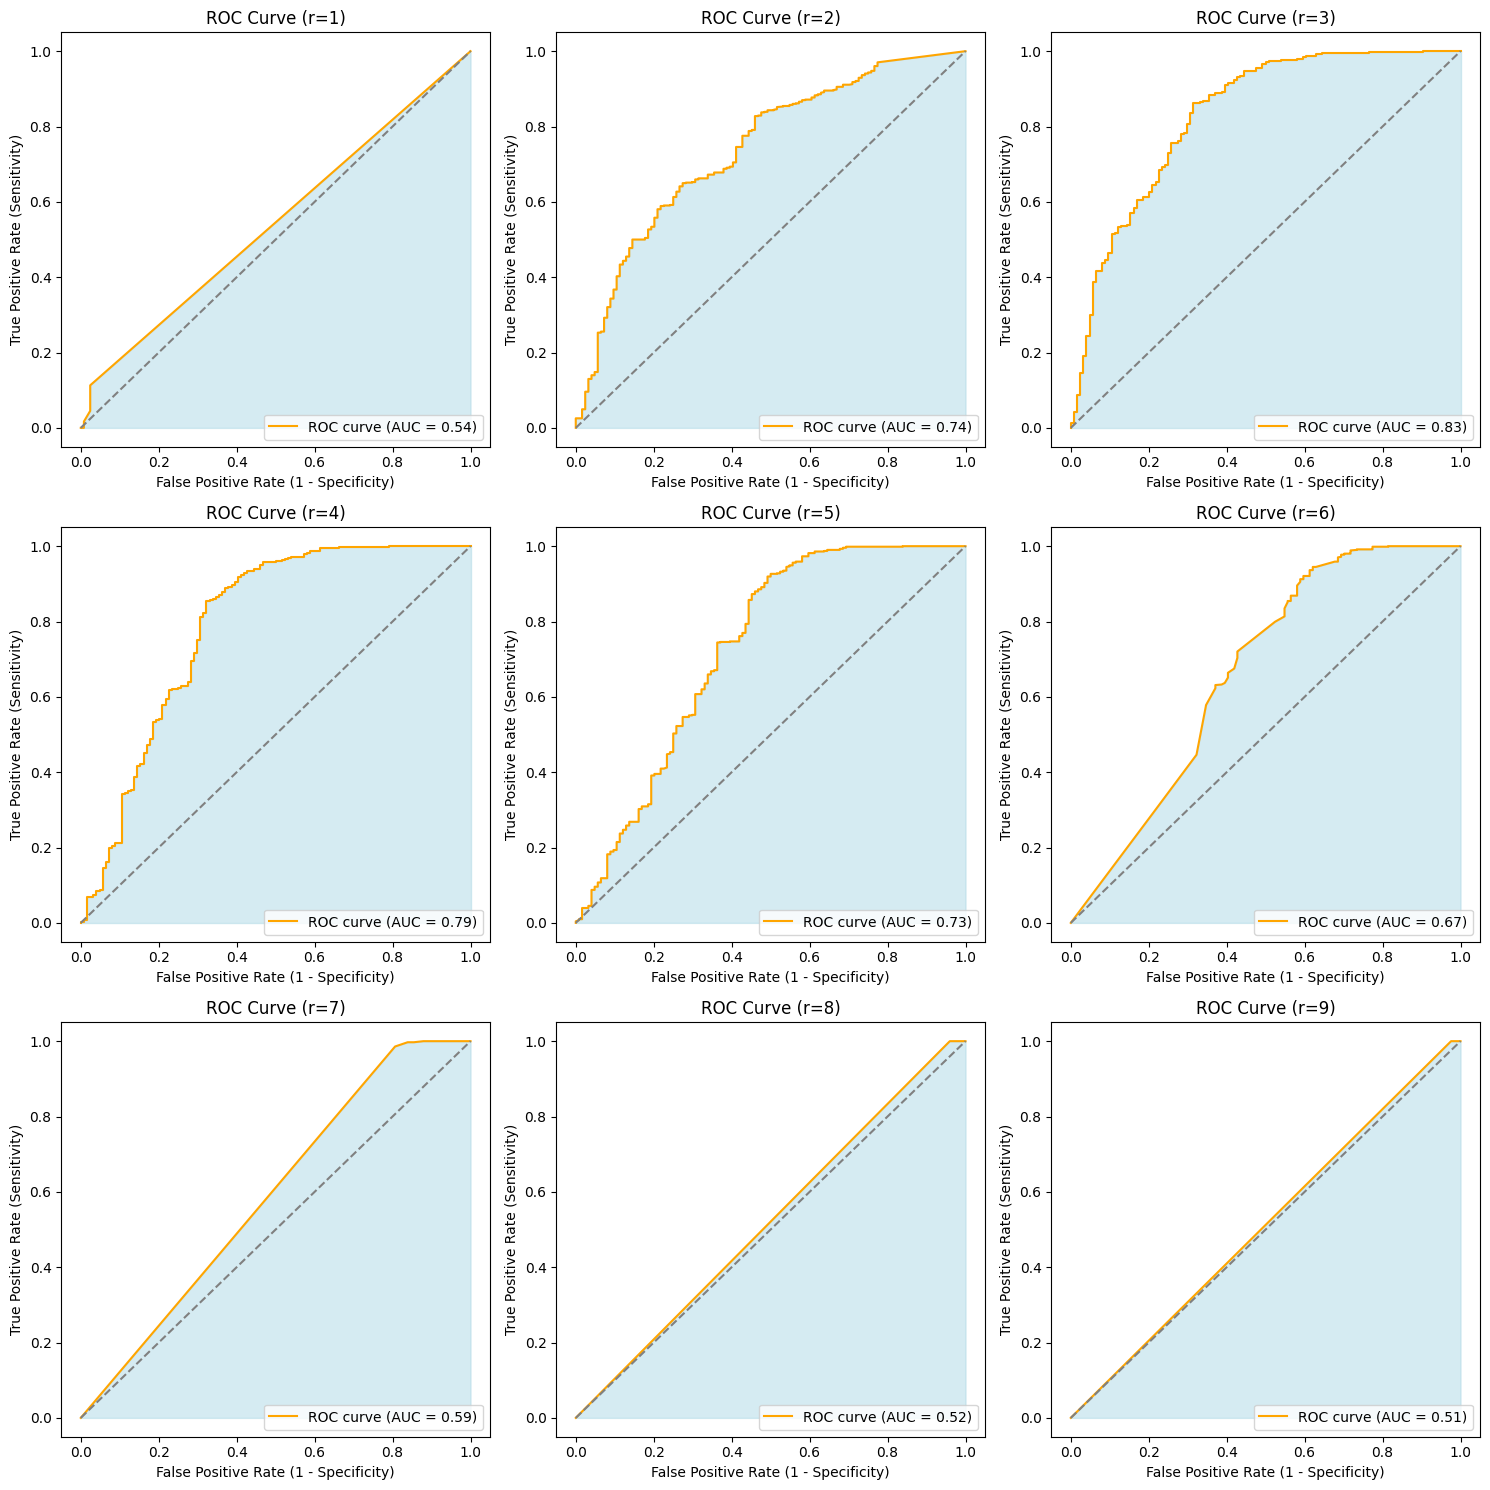

In [ ]:
run_experiment(test="tagalog.test", r_values=R_VALUES)

## Experiment 2: English and Middle-English

100%|██████████| 9/9 [02:17<00:00, 15.33s/it]


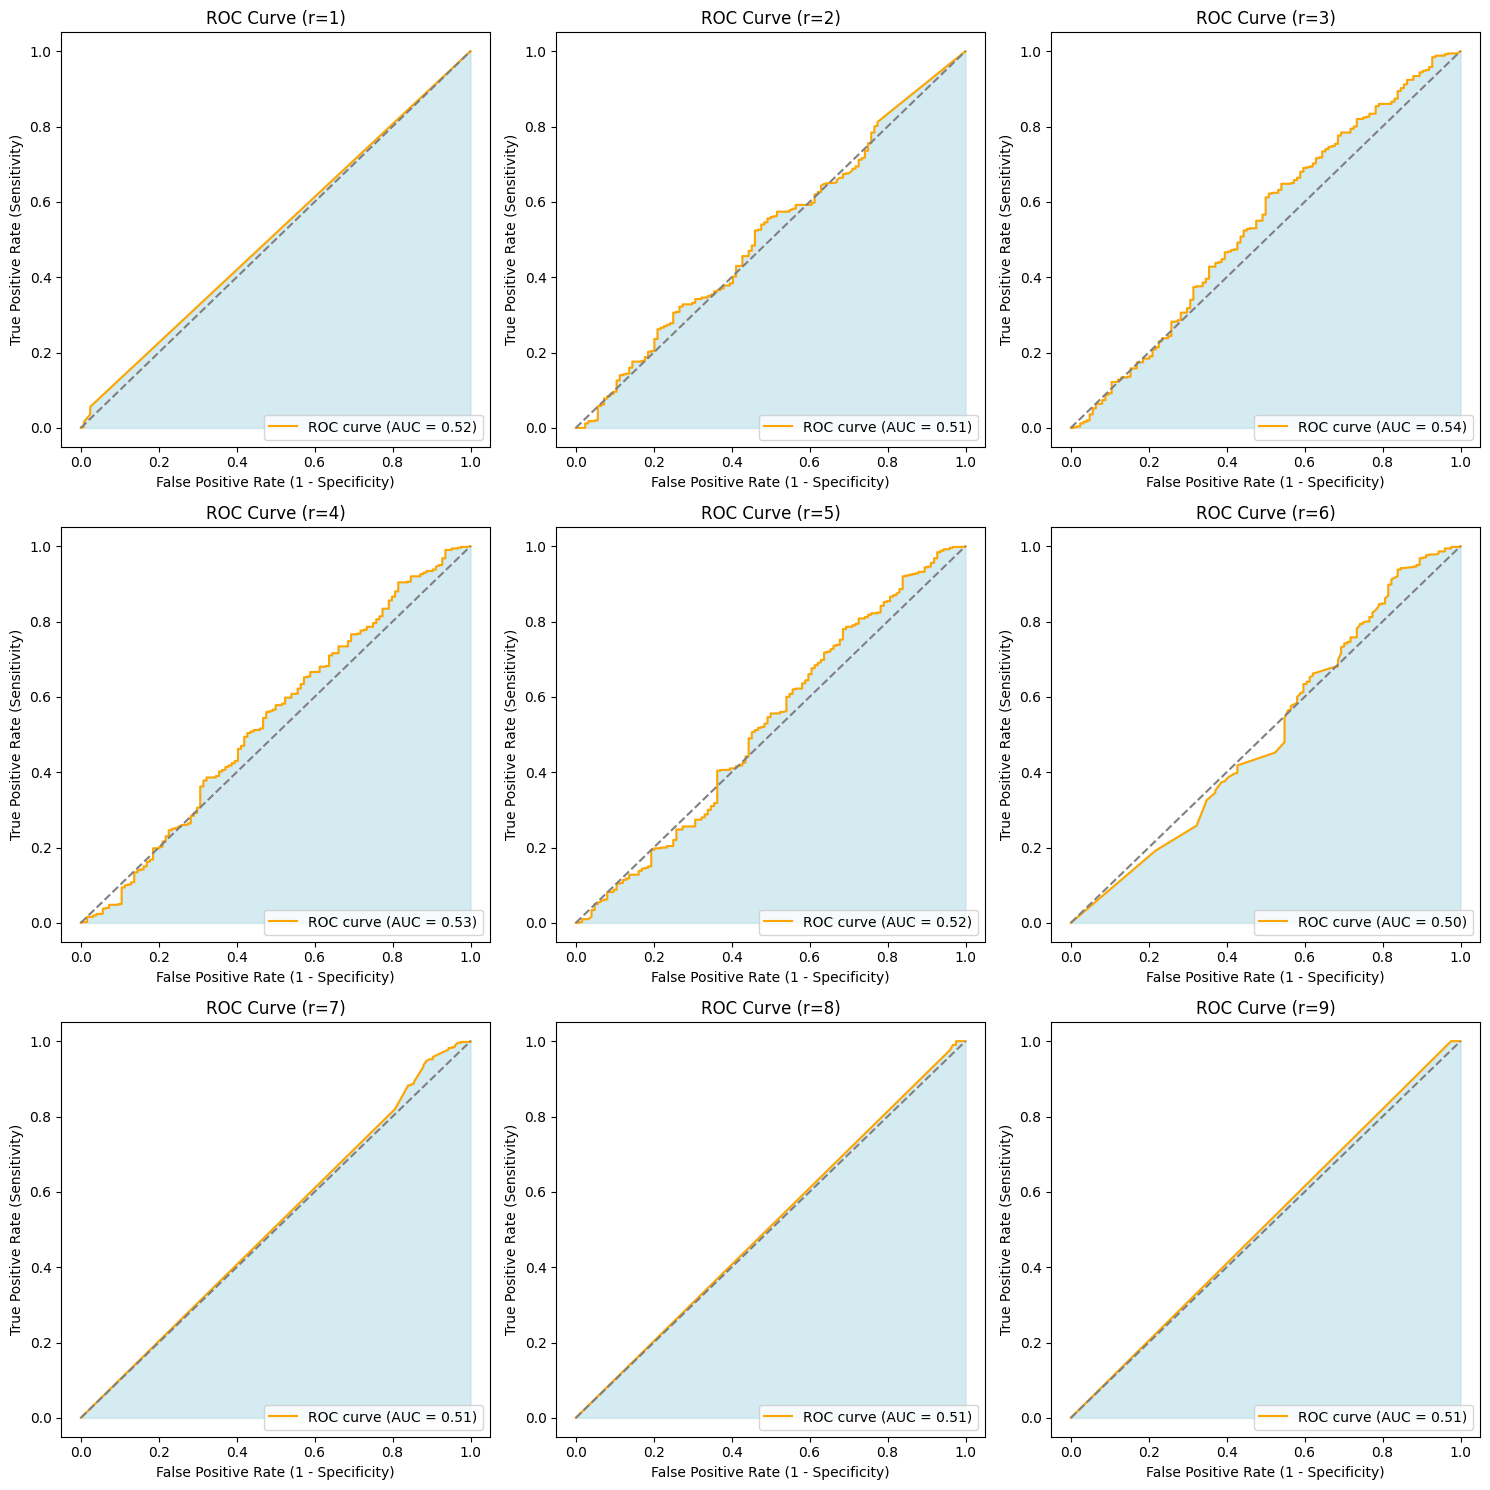

In [ ]:
run_experiment(test="lang/middle-english.txt", r_values=R_VALUES)

### Experiment 3: English and Plautdietsch

100%|██████████| 9/9 [02:03<00:00, 13.77s/it]


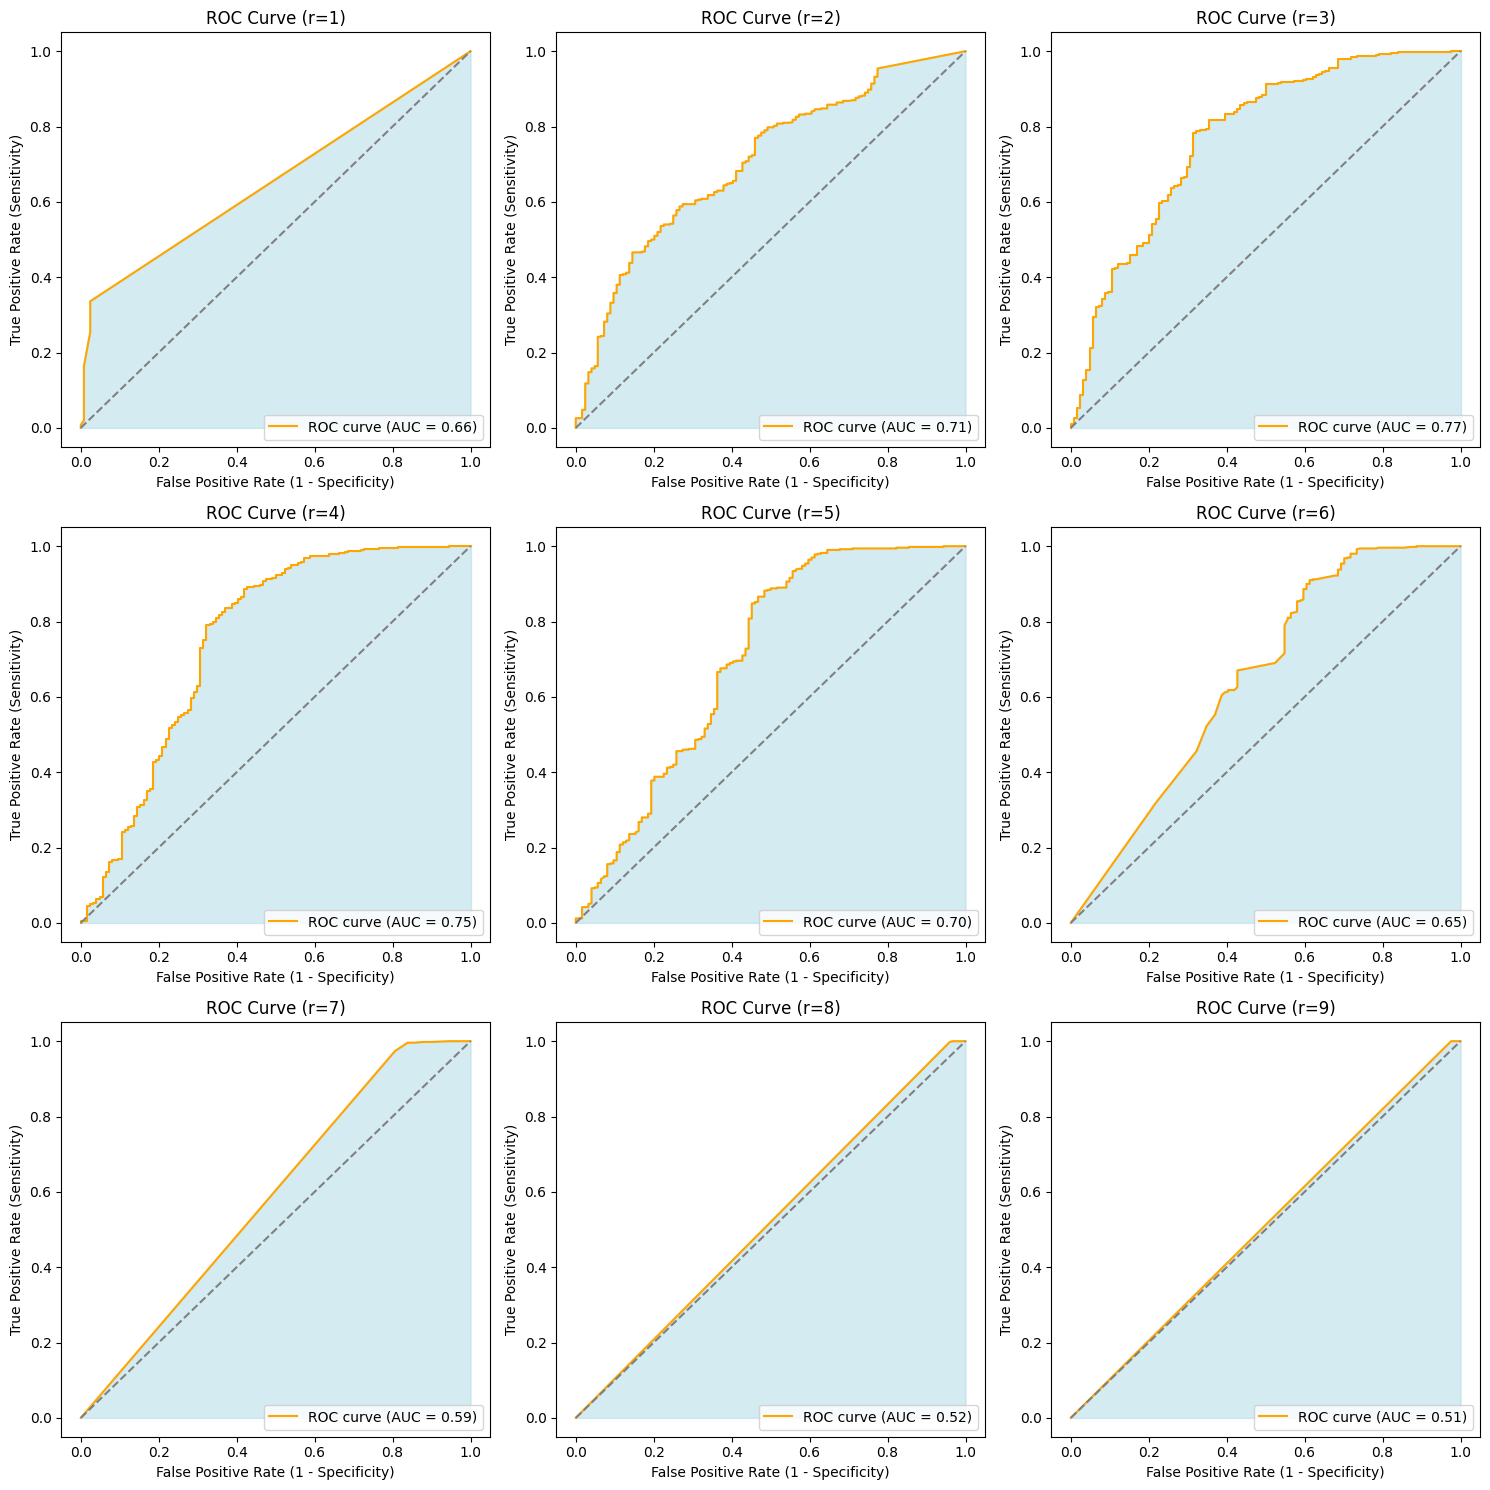

In [ ]:
run_experiment(test="lang/plautdietsch.txt", r_values=R_VALUES)

### Experiment 4: English and Hiligaynon

100%|██████████| 9/9 [02:02<00:00, 13.61s/it]


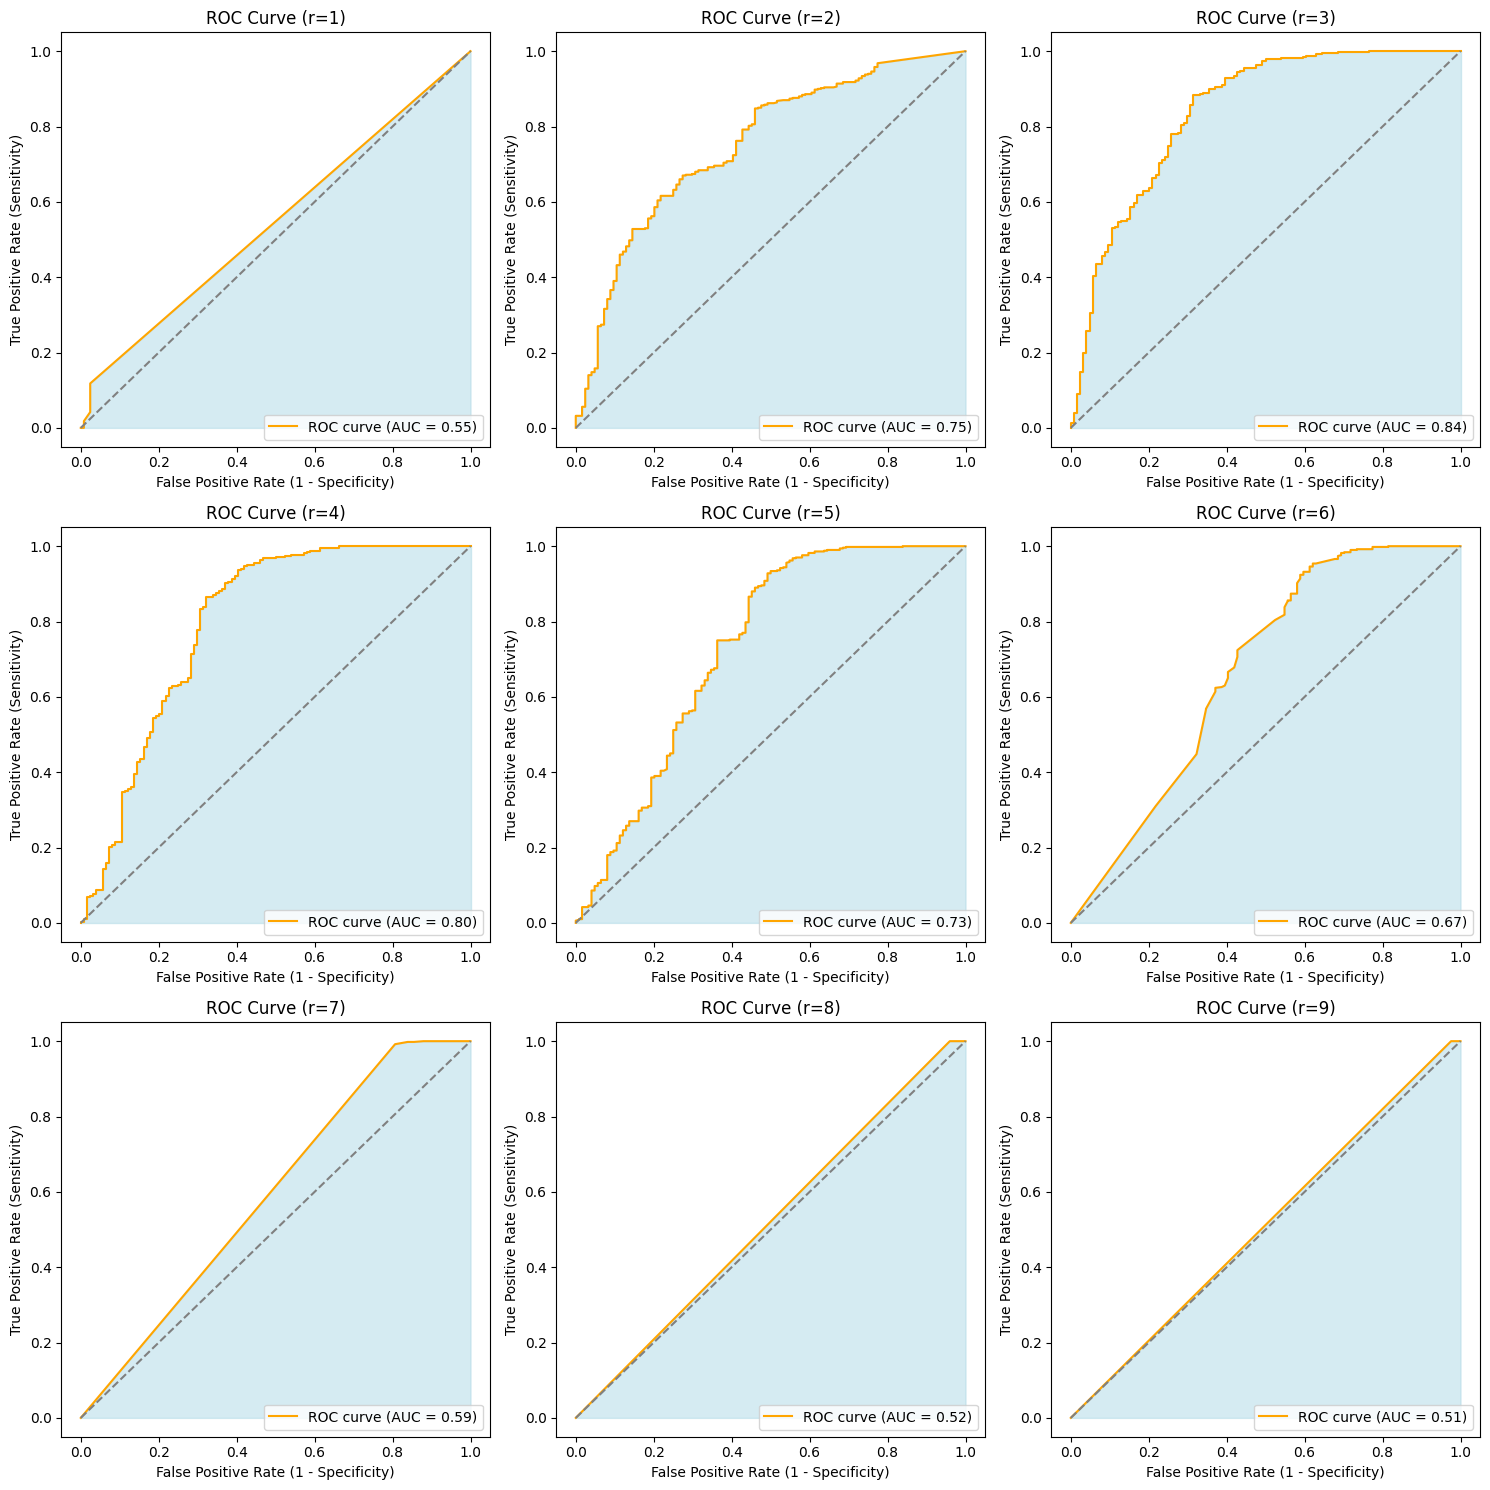

In [ ]:
run_experiment(test="lang/hiligaynon.txt", r_values=R_VALUES)

## Experiment 5: English and Xhosa

100%|██████████| 9/9 [01:57<00:00, 13.09s/it]


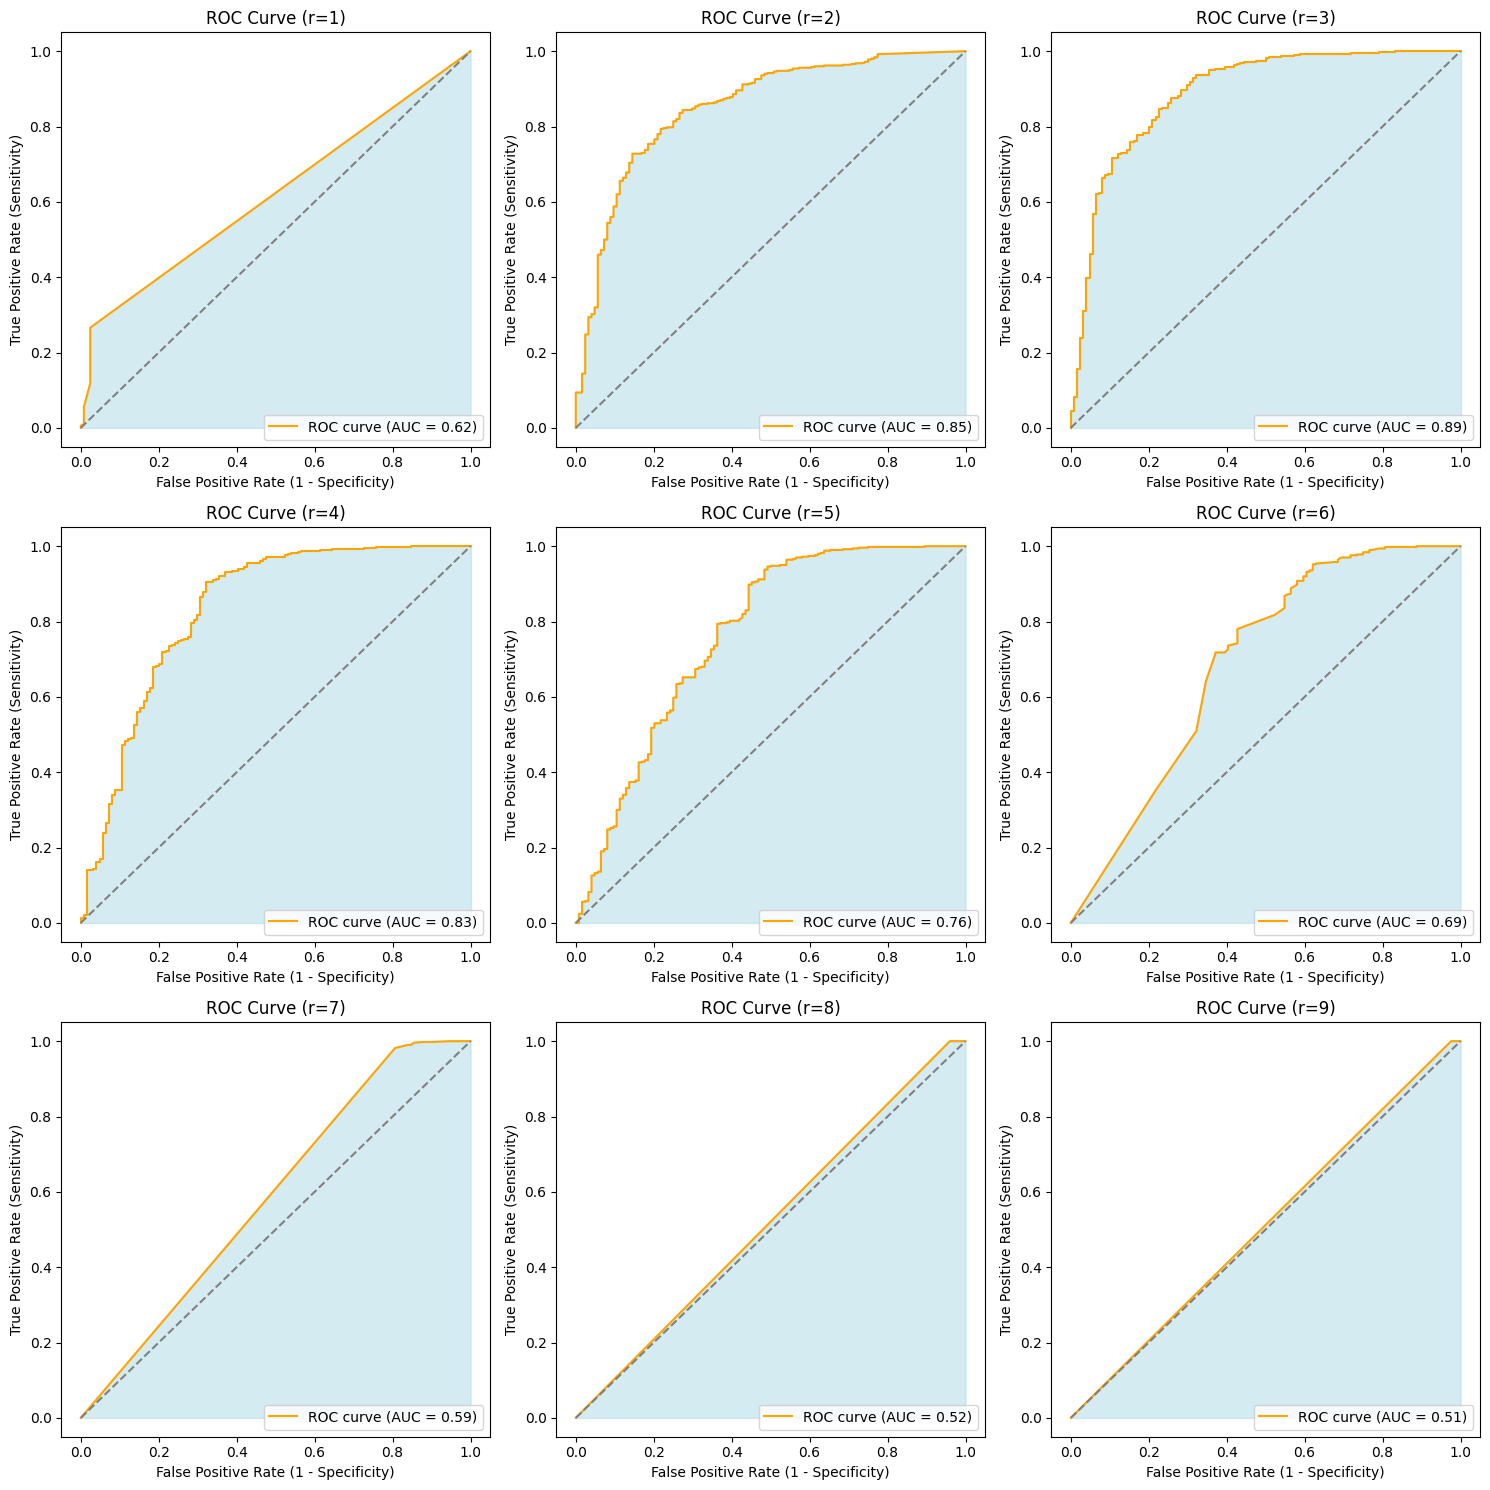

In [ ]:
run_experiment(test="lang/xhosa.txt", r_values=R_VALUES)